##Install dependencies

In [1]:
!git clone https://github.com/openai/glide-text2im.git
%cd glide-text2im
!pip install -q -e .
!pip install gdown

Cloning into 'glide-text2im'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 76 (delta 23), reused 19 (delta 19), pack-reused 37
Unpacking objects: 100% (76/76), done.
/content/glide-text2im
     |████████████████████████████████| 53 kB 1.1 MB/s 


In [2]:
import torch
!pip install bitsandbytes-cuda{''.join(c for c in torch.version.cuda if c.isdigit())}

     |████████████████████████████████| 4.3 MB 10.4 MB/s 


In [3]:
!nvidia-smi

Mon May 16 05:54:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Google Drive 연동
아래 코드를 실행후 나오는 URL을 클릭하여 나오는 인증 코드 입력

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Path 추가**

In [7]:
import sys
sys.path.append('drive/My Drive/')

### Set-up functions, models and options

In [4]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_gaussian_diffusion,
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [5]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
fp16 = False  #@param {type: "boolean"}
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options["use_fp16"] = has_cuda and fp16
options["timestep_respacing"] = "1000"  # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda and fp16:
    model.convert_to_fp16()
model.to(device)
#@markdown path to checkpoint to load, leave empty for default checkpoint
checkpoint_path = "" #@param {type: "string"}
if not checkpoint_path:
    checkpoint_path = load_checkpoint("base", device)
checkpoint = th.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
print("total base parameters", sum(x.numel() for x in model.parameters()))

In [11]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda and fp16
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda and fp16:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [12]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

### Resolution settings

In [13]:
#@title resolution settings

#@markdown the resolution goes up to 192x128 on a 12GB K80. it takes 2 minutes to generate at 128x64 and 10 for 256x128.

#@markdown the final resolution of the image after upsampling will be 4x higher 

side_x = 64  #@param {type: "integer"}
side_y =   64#@param {type: "integer"}
upsample_x = 4  #@param {type: "integer"}

##Fine-tuning

In [14]:
#@title image to tune with
import torch
import requests
import numpy as np
from PIL import Image


preprocess = lambda xs: torch.from_numpy(np.stack([np.asarray(x.resize((side_x, side_y)).convert("RGB")) for x in xs], axis=0)).permute(0, 3, 1, 2) / 127. - 1.
# download = lambda x: preprocess([Image.open(requests.get(x, stream=True).raw)])
# img_path = "https://cdn.discordapp.com/attachments/730484623028519072/926386737167622175/unknown.png" #@param ["https://cdn.discordapp.com/attachments/869675061211181107/924292876601540638/Title.jpg", "https://cdn.discordapp.com/attachments/730484623028519072/926386737167622175/unknown.png"] {type: "string", allow-input: true} 
# t = download(img_path)
# t.shape
# show_images(t)

In [ ]:
#@title (optional) multiple additional images
import gdown
import glob


#@markdown leave empty if you upload your own zip file
# gdown_link = "1cNrxEGPyzFazxyhgRAgKj7wU-IYp20W-" #@param ["", "1cNrxEGPyzFazxyhgRAgKj7wU-IYp20W-"] {type: "string", allow-input: true}
#@markdown path to the zip file. change this to the name of your own, leave empty if your images are already extracted.
# zip_path = "ffhq.zip"  #@param ["", "ffhq.zip", "dataset.zip"] {type: "string", allow-input: true}
#@markdown a specification of your input files. leave empty if there are no files
files_glob = "/*.jpg"  #@param ["", "**/*.jpg", "**/*.png", "ffhq/*.jpg"] {type: "string", allow-input: true}
#@markdown how many images to use and process?
train_imgs =   200#@param {type: "integer"}


# if gdown_link is not None:
#   zip_path = "dataset.zip"
#   gdown.download(f"https://drive.google.com/uc?id={gdown_link}", zip_path, quiet=False)
# if zip_path:
#   print("unzipping...")
#   !unzip -o {zip_path} > /dev/null 2> /dev/null
files = glob.glob(files_glob)
print(glob.glob(files_glob))
if files:
  files = list(map(Image.open, files[:train_imgs]))
  t = preprocess(files)
  row_size, show_total = 10, 100  # TODO
  show_total = min(show_total, len(files))
  for i in range(0, show_total, row_size):
    show_images(t[i:i+row_size])

In [36]:
#@title sampling parameters
prompt = "Elone musk" #@param {type: "string", allow-input: true} ["a picture of a face", "an landscape painting of switzerland", "an oil painting of a cat"]

batch_size = 4  #@param {type: "integer"}
sample_steps =   50#@param {allow-input: true}
guidance_scale = 0.0  #@param {type: "number"}
upsample_temp = 0.997  #@param {type: "number"}

In [37]:
##############################
#@title Sample from the base model #
##############################
from IPython.display import display, clear_output
from ipywidgets import Output
import torch


out = Output()
display(out)


eval_diffusion = create_gaussian_diffusion(
    steps=options["diffusion_steps"],
    noise_schedule=options["noise_schedule"],
    timestep_respacing=str(sample_steps),
)


# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    # print(ts)
    model_out = model(combined,
                      ts,
                      **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    beta = eval_diffusion.betas[int(ts.flatten()[0].item() / options["diffusion_steps"] * len(eval_diffusion.betas))]
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    with out:
        clear_output()
        show_images((x_t - eps * (beta ** 0.5))[:batch_size])
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
def sample(prompt=prompt):
    model.del_cache()

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )
    with torch.inference_mode():
        samples = eval_diffusion.p_sample_loop(
            model_fn,
            (full_batch_size, 3, side_y, side_x),  # only thing that's changed
            device=device,
            clip_denoised=True,
            progress=True,
            model_kwargs=model_kwargs,
            cond_fn=None,
        )[:batch_size]
    model.del_cache()
    return samples


sample()
0

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

0

In [ ]:
#@title training
from tqdm.auto import trange, tqdm

import os
import gc
import random
import bitsandbytes as bnb
from itertools import cycle
from more_itertools import chunked
from matplotlib import pyplot as plt
from IPython.display import clear_output


model.zero_grad()
try:
    del optim
    del xs
    del out
    del loss
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()
seed = 0
learning_rate = 2e-5  #@param {type: "number"}
model.requires_grad_(True)

train_fp16 = False  #@param {type: "boolean"}
adam8bit = False  #@param {type: "boolean"}
if not adam8bit:
    optim_class = th.optim.Adam
else:
    optim_class = bnb.optim.Adam8bit
optim = optim_class([x for x in model.parameters() if x.requires_grad], lr=learning_rate)

batch_size = 4  #@param {type: "integer"}
grad_acc = 1  #@param {type: "integer"}
epochs =     50#@param {type: "integer"}
sample_every =   1000  #@param {type: "integer"}
respace =   True  #@param {type: "boolean"}

save_path = "/checkpoint/"  #@param {type: "string"}
os.makedirs(save_path, exist_ok=True)
save_every = 500  #@param {type: "integer"}

# prompts disabled
# # Create the text tokens to feed to the model.
# tokens = model.tokenizer.encode(prompt)
# tokens, mask = model.tokenizer.padded_tokens_and_mask(
#     tokens, options['text_ctx']
# )
# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size  # * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        # [tokens] * batch_size + 
        [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        # [mask] * batch_size + 
        [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    # print(arr.shape, timesteps.shape)
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    # res = th.gather(res, 0, timesteps)
    # print(res.shape, timesteps.shape)# [timesteps].float()
    # print("before while")
    # return
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


out = Output()
display(out)
losses = []
bar = trange(epochs * t.shape[0])
l = 0
if not seed:
    seed = random.getrandbits(32)
    print("seed:", seed)
random.seed(seed)
torch.manual_seed(seed)
try:
    model.train()
    xs = list(t.detach().clone())
    random.shuffle(xs)
    for i, x in zip(bar, chunked(cycle(torch.stack(xs)), full_batch_size)):
        with torch.cuda.amp.autocast(enabled=train_fp16):
            x = torch.stack(x, dim=0).to(device)
            ts = torch.randint(0, len(diffusion.betas)-1,
                               (full_batch_size,)).to(x.device)
            orig_noise = th.randn_like(x, device=x.device)
            if respace:
                ts = ts // (options["diffusion_steps"] // len(diffusion.betas))
            x_t = diffusion.q_sample(x, ts, noise=orig_noise)
            output = model(x_t, ts, **model_kwargs)
            eps = output[..., :3, :, :]
            loss = th.nn.functional.mse_loss(eps, orig_noise.detach())
        l += loss.item()
        loss.backward()
        if i % grad_acc == grad_acc - 1:
            optim.step()
            optim.zero_grad()
            l /= grad_acc
            bar.set_description(f"loss: {l}")
            losses.append(l)
            l = 0
            with out:
                clear_output()
                plt.plot(losses)
                plt.show()
        if i % sample_every == 0:
            samples = sample()
            out = Output()
            display(out)
        if i % save_every == save_every - 1:
            torch.save(model.state_dict(), os.path.join(save_path, f"{i}.pth"))
except KeyboardInterrupt:
    pass

### Show the output of sampling at your resolution

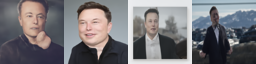

In [39]:
show_images(samples)

### Upsample to 4x resolution

In [40]:
##############################
#@title Upsample the low-res images #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, side_y * upsample_x, side_x * upsample_x)
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

  0%|          | 0/27 [00:00<?, ?it/s]

### Show the output

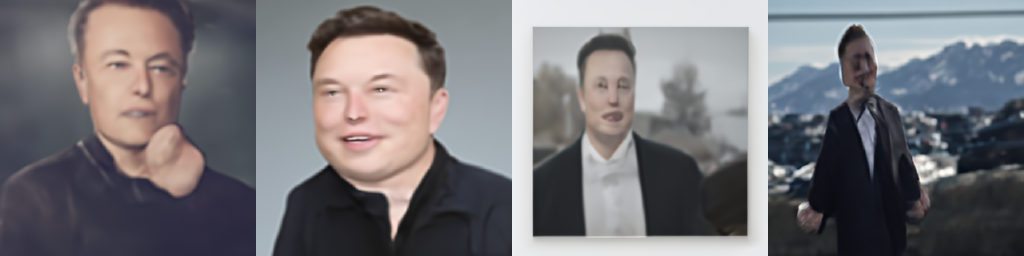

In [41]:
show_images(up_samples)